### Import TensorFlow2 and other libraries

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0-alpha0'

pip install Pillow
pip install matplotlib
pip install imageio
pip install opencv-python

In [4]:
import time
import datetime
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import imageio
from PIL import Image
import cv2
import PIL

from IPython import display

%matplotlib inline

In [5]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Load and prepare the dataset



In [6]:
# Paths Setting
#INPUT_DATA_DIR = './simpsons-faces/simplified/'
INPUT_DATA_DIR = './simpsons-faces/cropped/'
OUTPUT_DIR = './{date:%Y-%m-%d_%H%M%S}/'.format(date=datetime.datetime.now())

OUTPUT_LOSS_DIR = OUTPUT_DIR + 'loss/'
OUTPUT_IMG_DIR = OUTPUT_DIR + 'images/'
OUTPUT_WEIGHT_DIR = OUTPUT_DIR + 'weight/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

if not os.path.exists(OUTPUT_LOSS_DIR):
    os.makedirs(OUTPUT_LOSS_DIR)

if not os.path.exists(OUTPUT_IMG_DIR):
    os.makedirs(OUTPUT_IMG_DIR)
    
if not os.path.exists(OUTPUT_WEIGHT_DIR):
    os.makedirs(OUTPUT_WEIGHT_DIR)    

In [7]:
exclude_file_list = ["9746","9731","9717","9684","9637","9641","9642","9584","9541","9535",
                     "9250","9251","9252","9043","8593","8584","8052","8051","8008","7957",
                     "7958","7761","7762","9510","9307","4848","4791","4785","4465","2709",
                     "7724","7715","7309","7064","7011","6961","6962","6963","6960","6949",
                     "6662","6496","6409","6411","6406","6407","6170","6171","6172","5617",
                     "4363","4232","4086","4047","3894","3889","3493","3393","3362","2780",
                     "2710","2707","2708","2711","2712","2309","2056","1943","1760","1743",
                     "1702","1281","1272","772","736","737","691","684","314","242","191"]

for ex_image in exclude_file_list:
    if os.path.exists(f'{INPUT_DATA_DIR}{ex_image}.png'):
        print(f'{INPUT_DATA_DIR}{ex_image}.png')
        os.rename(f'{INPUT_DATA_DIR}{ex_image}.png', f'{INPUT_DATA_DIR}{ex_image}.png_bak')


In [8]:
# Hyperparameters
IMAGE_SIZE = 128
NOISE_SIZE = 100
LR_D = 0.00004
LR_G = 0.0004
BATCH_SIZE = 64
EPOCHS = 300
BETA1 = 0.5
WEIGHT_INIT_STDDEV = 0.02
EPSILON = 0.00005
SAMPLES_TO_SHOW = 16    # 5 > 16
BUFFER_SIZE = 1000     # 10240 ?

In [9]:
display_noise = tf.random.uniform(shape=[SAMPLES_TO_SHOW, NOISE_SIZE], minval=-1, maxval=1, dtype=tf.dtypes.float32)
print(display_noise[0][0:5])

w_init = tf.initializers.TruncatedNormal(stddev=WEIGHT_INIT_STDDEV)
w_init

tf.Tensor([-0.5957866  -0.06263208 -0.00256133  0.39739084 -0.13603973], shape=(5,), dtype=float32)


In [10]:
def load_data(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img)
    img = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])[..., :3]
    img /= 127.5
    img -= 1
    return img

In [11]:
image_list = glob(INPUT_DATA_DIR + '*.png')
print('Found {} images'.format(len(image_list)))


Found 9796 images


In [12]:
image_dataset = tf.data.Dataset.from_tensor_slices(image_list)

In [13]:
image_dataset = image_dataset.shuffle(buffer_size=BUFFER_SIZE)

In [14]:
image_dataset = image_dataset.map(load_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [15]:
image_dataset = image_dataset.batch(BATCH_SIZE)

In [16]:
image_dataset = image_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Create the models



### The Generator



In [17]:
def make_generator_model(generator_dim=100):
    
    noise = tf.keras.layers.Input(shape=(generator_dim,), name='generator_noise_input')
    
    # 1024x8x8 = 262,144
    x = tf.keras.layers.Dense(8*8*1024)(noise)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    # 8x8x1024
    x = tf.keras.layers.Reshape(target_shape=[8, 8, 1024])(x)
    print(x.shape)
    
    # 1. 16x16x1024 -> 32x32x512
    x = tf.keras.layers.Conv2DTranspose(filters=512,
                                        kernel_size=5,
                                        strides=2,
                                        padding='same',
                                        kernel_initializer=w_init,
                                        use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.ReLU()(x)
    print(x.shape)
    
    # 2. 32x32x512 -> 64x64x256
    x = tf.keras.layers.Conv2DTranspose(filters=256,
                                        kernel_size=5,
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=w_init,
                                        use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.ReLU()(x)
    print(x.shape)
    
    # 3. 64x64x256 -> 128x128x128
    x = tf.keras.layers.Conv2DTranspose(filters=128,
                                        kernel_size=5,
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=w_init,
                                        use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.ReLU()(x)
    print(x.shape)
    
    # 4. 128x128x128 -> 256x256x64
    x = tf.keras.layers.Conv2DTranspose(filters=64,
                                        kernel_size=5,
                                        strides=2, 
                                        padding='same',
                                        kernel_initializer=w_init,
                                        use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.ReLU()(x)
    print(x.shape)
    
    # 256x256x64 -> 512x512x32
    x = tf.keras.layers.Conv2DTranspose(filters=3,
                                        kernel_size=5,
                                        strides=1, 
                                        padding='same',
                                        kernel_initializer=w_init,
                                        use_bias=True)(x)
    print(x.shape)
    
    fake_output = tf.keras.layers.Activation('tanh', name='logits')(x)
    print(fake_output)
    
    return tf.keras.Model(inputs=[noise], outputs=[fake_output], name='Generator')


In [18]:
generator = make_generator_model(NOISE_SIZE)

generated_image = generator(display_noise, training=False)
print ("Input: " + str(generated_image.shape))

images = tf.clip_by_value((generated_image + 1) * 127.5, 0, 255).numpy()
for i in range(16):
    cv2.imwrite(f'{OUTPUT_IMG_DIR}generated_noise_{i}.png', cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR))

(None, 8, 8, 1024)
(None, 16, 16, 512)
(None, 32, 32, 256)
(None, 64, 64, 128)
(None, 128, 128, 64)
(None, 128, 128, 3)
Tensor("logits/Tanh:0", shape=(None, 128, 128, 3), dtype=float32)
Input: (16, 128, 128, 3)


### The Discriminator



In [19]:
def make_discriminator_model(latent_dim=100):
    
    image_input = tf.keras.layers.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3], name='discriminator_image_input')
    print(image_input.shape)
    
    # 128*128*3 -> 64x64x64 
    x = tf.keras.layers.Conv2D(filters=64,
                               kernel_size=5,
                               strides=2, 
                               padding='same',
                               kernel_initializer=w_init,
                               use_bias=True)(image_input)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    print(x.shape)
    
    # 64x64x64-> 32x32x128 
    x = tf.keras.layers.Conv2D(filters=128,
                               kernel_size=5,
                               strides=2, 
                               padding='same',
                               kernel_initializer=w_init,
                               use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    print(x.shape)

    # 32x32x128 -> 16x16x256  
    x = tf.keras.layers.Conv2D(filters=256,
                               kernel_size=5,
                               strides=2, 
                               padding='same',
                               kernel_initializer=w_init,
                               use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    print(x.shape)

    # 16x16x256 -> 16x16x512
    x = tf.keras.layers.Conv2D(filters=512,
                               kernel_size=5,
                               strides=1, 
                               padding='same',
                               kernel_initializer=w_init,
                               use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    print(x.shape)
    
    # 16x16x512 -> 8x8x1024
    x = tf.keras.layers.Conv2D(filters=1024,
                               kernel_size=5,
                               strides=2,
                               padding='same',
                               kernel_initializer=w_init,
                               use_bias=True)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=EPSILON)(x)
    x = tf.keras.layers.LeakyReLU()(x)
    print(x.shape)
    
    x = tf.keras.layers.Reshape(target_shape=(-1, 8*8*1024))(x)
    logits = tf.keras.layers.Dense(units=1, activation=None)(x)
    print(logits)
    
    return tf.keras.Model(inputs=[image_input], outputs=[logits], name='Discriminator')


In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision.shape)
#print (decision)

(None, 128, 128, 3)
(None, 64, 64, 64)
(None, 32, 32, 128)
(None, 16, 16, 256)
(None, 16, 16, 512)
(None, 8, 8, 1024)
Tensor("dense_1/BiasAdd:0", shape=(None, None, 1), dtype=float32)
(16, 1, 1)


## Define the loss and optimizers




### Discriminator loss



In [21]:
def d_loss_real_function(d_logits_real):
    
    # Discriminator logic
    d_model_real = tf.sigmoid(d_logits_real)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)*random.uniform(0.9, 1.0)))
    
    return d_model_real, d_loss_real


def d_loss_fake_function(d_logits_fake):
    
    # Discriminator logic
    d_model_fake = tf.sigmoid(d_logits_fake)
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    
    return d_model_fake, d_loss_fake

### Generator loss



In [22]:
def g_loss_function(d_logits_fake, d_model_fake):
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    return g_loss


### optimizers



In [23]:
d_optimizer = tf.keras.optimizers.Adam(learning_rate=LR_D, beta_1=BETA1)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=LR_G, beta_1=BETA1)


### Save checkpoints




In [24]:
checkpoint_dir = OUTPUT_DIR + 'training_checkpoints'

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)    

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=g_optimizer,
                                 discriminator_optimizer=d_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop



In [25]:
print(display_noise)


tf.Tensor(
[[-0.5957866  -0.06263208 -0.00256133 ...  0.8981807  -0.5727241
  -0.90593815]
 [-0.29501343 -0.5604212  -0.02305651 ... -0.5291705   0.16466665
  -0.8487563 ]
 [ 0.11982012  0.20610762 -0.89783144 ...  0.5441675  -0.6646979
  -0.2737913 ]
 ...
 [ 0.9217372  -0.01761842  0.9868853  ... -0.08641362 -0.8568971
  -0.19696426]
 [ 0.8338301   0.8840208   0.01521564 ...  0.33763766  0.2860353
  -0.99901414]
 [ 0.85625887 -0.14078236 -0.21062899 ...  0.9608319  -0.34490156
  -0.71682   ]], shape=(16, 100), dtype=float32)


In [26]:
@tf.function
def training_step(images):
    
    noise = tf.random.uniform(shape=[BATCH_SIZE, NOISE_SIZE], minval=-1, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape, tf.GradientTape() as r_tape:

        # noise generator > discriminator
        g_model = generator(noise, training=True)
        
        d_logits_fake = discriminator(g_model, training=True)
        
        d_model_fake, d_loss_fake = d_loss_fake_function(d_logits_fake)
        
        
        # noise readl > discriminator 
        noisy_input_real = images + tf.random.normal(shape=tf.shape(images),
                                                     mean=0.0,
                                                     stddev=random.uniform(0.0, 0.1),
                                                     dtype=tf.dtypes.float32)
        
        d_logits_real = discriminator(noisy_input_real, training=True)
        
        d_model_real, d_loss_real = d_loss_real_function(d_logits_real)

        
        # discriminator loss
        d_loss = tf.reduce_mean(0.5 * (d_loss_real + d_loss_fake))
        
        # generator loss
        g_loss = g_loss_function(d_logits_fake, d_model_fake)

        discriminator_gradients_fake = d_tape.gradient(d_loss, discriminator.trainable_variables)
        generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)

        d_optimizer.apply_gradients(zip(discriminator_gradients_fake, discriminator.trainable_variables))
        g_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

    return g_loss, d_loss

In [27]:
def train(epochs=10, save_every=3, steps=None):
    
    d_losses = []
    g_losses = []
    summary_step = 0
    
    for ep in range(epochs):
        
        start = time.time()
        
        running_loss = {'g_loss': [], 'd_loss': []}
        for step, images in enumerate(image_dataset):
            
            batch_g_loss, batch_d_loss = training_step(images)
            
            # loss write
            d_losses.append(batch_d_loss.numpy())
            g_losses.append(batch_g_loss.numpy())
            
            if step % 10 == 0:
                ctime = time.strftime("%Y/%m/%d/ %H:%M:%S")
                print(f'||epoch {ep}/{epochs} step {step+1}/{steps}|G_LOSS : {batch_g_loss:.3f}|D_LOSS : {batch_d_loss:.3f}|| {ctime}' )
            
            tf.summary.scalar("generator_batch_loss", batch_g_loss, step=summary_step + 1)
            tf.summary.scalar("discriminator_batch_loss_total", batch_d_loss, step=summary_step + 1)
            writer.flush()
            
            summary_step = summary_step + 1
        
        if ep % save_every == 0:
            print(f'||saving weights for epoch : {ep}||')
            generator.save_weights(f'{OUTPUT_WEIGHT_DIR}generator_weights_{ep}.h5')
            discriminator.save_weights(f'{OUTPUT_WEIGHT_DIR}discriminator_weights_{ep}.h5')
            checkpoint.save(file_prefix = checkpoint_prefix)
        
        display.clear_output(wait=True)
        print ('Time for epoch [{}] is [{}] sec'.format(ep, time.time()-start))

        # test noise not change for gif gen
        #display_noise = tf.random.uniform(shape=[SAMPLES_TO_SHOW, NOISE_SIZE], minval=-1, maxval=1, dtype=tf.dtypes.float32)
        save_generated_images(display_noise, epoch=ep)
        
        summarize_epoch(ep, time.time()-start, d_losses, g_losses)
            
    return d_losses, g_losses

**Generate and save images**




In [28]:
def save_generated_images(noise, epoch=None):
    
    images_result = generator(noise)
    
    # cv 
    images = tf.clip_by_value((images_result + 1) * 127.5, 0, 255).numpy()
    for i in range(16):
        cv2.imwrite(f'{OUTPUT_IMG_DIR}{i}_{epoch}.png', cv2.cvtColor(images[i], cv2.COLOR_RGB2BGR))
    
    # plt
    sample_images = [tf.cast((sample + 1) * 127.5, dtype=tf.uint8).numpy() for sample in images_result]
    fig = plt.figure(figsize=(6,6)) 

    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(sample_images[i])
        plt.axis('off')
    plt.savefig(OUTPUT_DIR + 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    plt.close()
    

In [29]:
def summarize_epoch(epoch, duration, d_losses, g_losses):
    
    minibatch_size = int(len(image_list)//BATCH_SIZE)
    
    print("Epoch {}/{}".format(epoch, EPOCHS),
          "\nDuration: {:.5f}".format(duration),
          "\nD Loss: {:.5f}".format(np.mean(d_losses[-minibatch_size:])),
          "\nG Loss: {:.5f}".format(np.mean(g_losses[-minibatch_size:])))
    
    fig, ax = plt.subplots()
    plt.plot(d_losses, label='Discriminator', alpha=0.6)
    plt.plot(g_losses, label='Generator', alpha=0.6)
    plt.title("Losses")
    plt.legend()
    plt.savefig(OUTPUT_LOSS_DIR + "losses_" + str(epoch) + ".png")
    plt.show()
    plt.close()


## Train the model



Time for epoch [300] is [213.60313892364502] sec


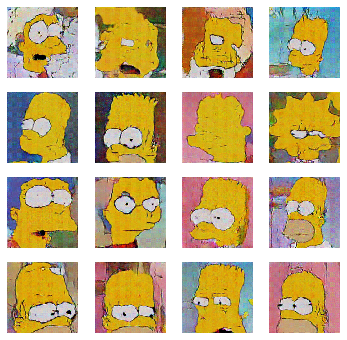

Epoch 299/300 
Duration: 214.56617 
D Loss: 0.17631 
G Loss: 4.64620


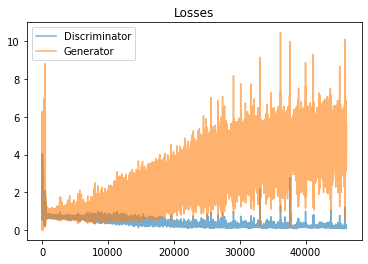

Wall time: 17h 36min 6s


In [30]:
%%time
writer = tf.summary.create_file_writer(OUTPUT_DIR + 'logs')
with writer.as_default():
    steps_per_epoch = len(image_list)//BATCH_SIZE
    d_losses, g_losses = train(EPOCHS, 10, steps_per_epoch)

## Restore the latest checkpoint.

In [31]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [32]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('{}image_at_epoch_{:04d}.png'.format(OUTPUT_DIR, epoch_no))

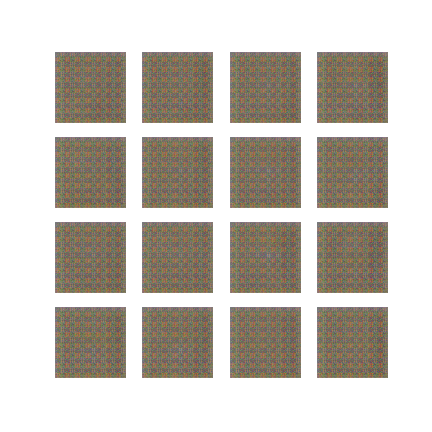

In [33]:
display_image(0)

In [34]:
anim_file = OUTPUT_DIR + 'dcgan_simsons_faces.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    
    filenames = glob(OUTPUT_DIR+'image*.png')
    filenames = sorted(filenames)
    
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        
        image = imageio.imread(filename)
        writer.append_data(image)
        
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython

if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)

In [36]:
anim_lfile = OUTPUT_DIR + 'dcgan_loss.gif'

with imageio.get_writer(anim_lfile, mode='I') as writer:
    
    filenames = glob(OUTPUT_LOSS_DIR+'losses_*.png')
    filenames = sorted(filenames)
    
    last = -1
    for i,filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        
        image = imageio.imread(filename)
        writer.append_data(image)
        
        image = imageio.imread(filename)
        writer.append_data(image)

import IPython

if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_lfile)

In [35]:
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(anim_file)